In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torchvision import transforms

import h5py

from tqdm import tqdm

In [2]:
device = torch.device('cuda')

## Data

In [3]:
torch.use_deterministic_algorithms(False)

torch_rng = torch.manual_seed(777)
np_rng = np.random.default_rng(777)

np.random.seed(777)

In [4]:
# TODO use data kept locally
train_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500000-diff-profile.hdf5")

In [5]:
# TODO use data kept locally
val_test_hdf = h5py.File("C:/Data/simpleserial-aes-fix-500-diff.hdf5")

In [6]:
# Non bitsliced
train_hdf = h5py.File("C:/Data/simpleserial-aes-500000-diff-profile.hdf5")
val_test_hdf = h5py.File("C:/Data/simpleserial-aes-500-diff.hdf5")

In [7]:
train_traces = torch.Tensor(np.array(train_hdf['trace']))

In [8]:
train_keys = torch.Tensor(np.array(train_hdf['key']))

In [9]:
val_test_traces = torch.Tensor(np.array(val_test_hdf['trace']))

In [10]:
val_test_keys = torch.Tensor(np.array(val_test_hdf['key']))

In [11]:
print(f"Train traces shape: {train_traces.shape}")
print(f"Train keys shape: {train_keys.shape}")

print(f"Test traces shape: {val_test_traces.shape}")
print(f"Test keys shape: {val_test_keys.shape}")

Train traces shape: torch.Size([500000, 5000])
Train keys shape: torch.Size([500000, 16])
Test traces shape: torch.Size([1000, 500, 5000])
Test keys shape: torch.Size([1000, 16])


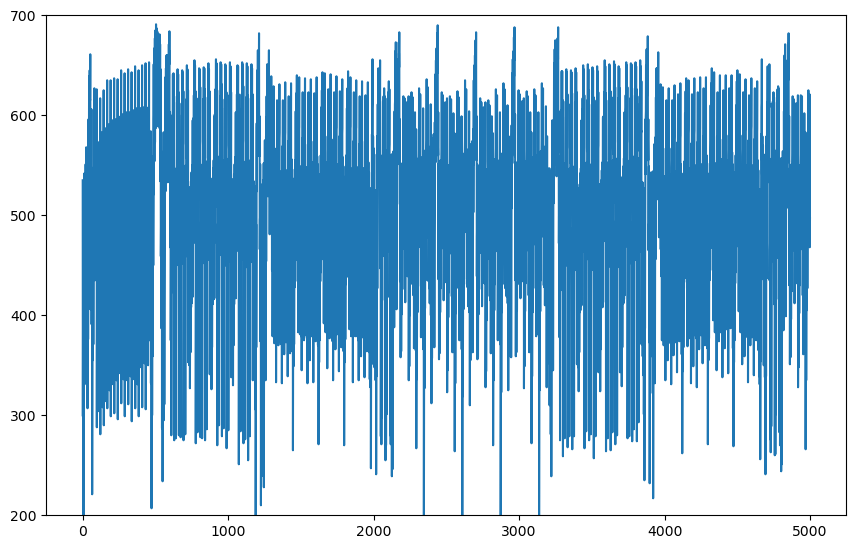

In [12]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), train_traces[99000])

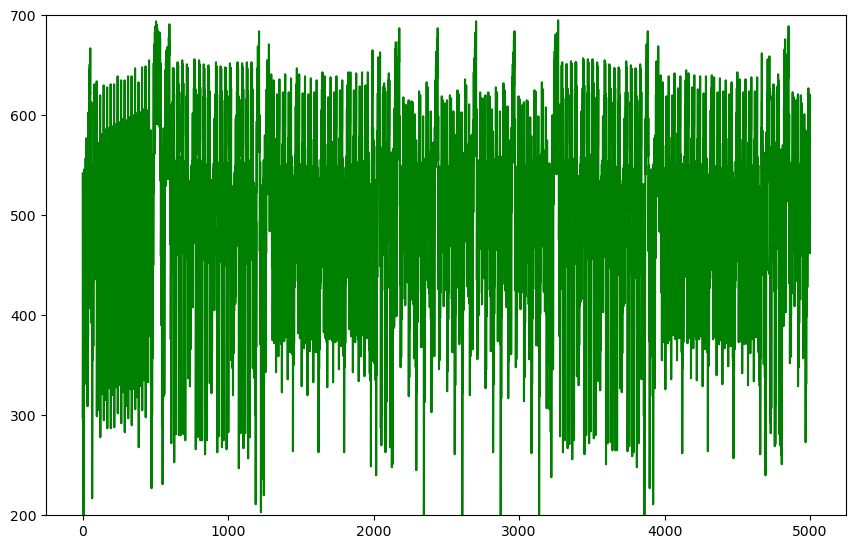

In [13]:
fig = plt.figure(1,(8.0, 5.0))
ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
ax.set_ylim(200.0, 700.0)

ax.plot(np.arange(5000), val_test_traces[450,4], color='green')

In [14]:
train_traces_trunc = train_traces[..., :1000]
val_test_traces_trunc = val_test_traces[..., :1000]

print(train_traces_trunc.shape)
print(val_test_traces_trunc.shape)

torch.Size([500000, 1000])
torch.Size([1000, 500, 1000])


In [15]:
train_traces_mean = train_traces_trunc.mean()
train_traces_std = train_traces_trunc.std()

In [16]:
train_traces_norm = (train_traces_trunc - train_traces_mean) / train_traces_std
val_test_traces_norm = (val_test_traces_trunc - train_traces_mean) / train_traces_std

## Dataset

In [17]:
class TrainingTraceSet(Dataset):
    def __init__(self, traces : torch.Tensor, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        sample = self.traces[idx]
        target = self.keys[idx]
        return (sample, target)

In [18]:
class TestingTraceSet(Dataset):
    def __init__(self, traces, keys, subkey_idx):

        self.traces = traces
        self.keys = keys[..., subkey_idx]

    def __len__(self):
        return self.traces.shape[0]
    
    def __getitem__(self, idx):
        # One sample, N traces
        traces = self.traces[idx]
        key = self.keys[idx]

        return (traces, key)

## Model

In [19]:
class SCACNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Flatten(),

            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            # Cross entropy expects raw logits
            # https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


In [20]:
class SCACNN_SQUEEZE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.network : nn.Sequential = nn.Sequential(
            
            nn.Conv1d(1, 64, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(64, 128, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(128, 256, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(256, 512, 11),
            nn.ReLU(),
            nn.AvgPool1d(2, 2),

            nn.Conv1d(512, 512, 11),
            nn.ReLU(),

            nn.AdaptiveMaxPool1d(512),

            nn.Linear(512, 512),
            nn.Sigmoid(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Softplus()
        )

    def forward(self, x):

        # Add channel dimension for conv
        x = x.unsqueeze(1)

        output = self.network(x)

        return output


## Training

In [21]:
def mean_keyrank2(model : nn.Module, test_loader : DataLoader):
    total_rank = 0
    
    for traces, key in tqdm(test_loader, 'computing keyrank'):

        traces = traces.to(device)
        key = key.to(device)

        output = model(traces.squeeze())

        _, rankings = torch.unique(-output, sorted=True, return_inverse=True, dim=-1)

        rankings = rankings.type(torch.float64)

        current_rank = (rankings * F.one_hot(key.long(), 256)).sum()

        # Multiply with one hot tensor to retain only rank of target class
        total_rank += current_rank


    mean_rank = total_rank / len(test_loader)

    return mean_rank


In [22]:
def mean_keyrank(model : nn.Module, test_loader : DataLoader):
    total_rank = 0

    for traces, key in tqdm(test_loader, 'computing keyrank'):

        traces = traces.to(device)
        key = key.to(device)

        output : torch.Tensor = model(traces.squeeze())

        ranks = output.argsort(dim=-1, descending=True).argsort(dim=-1)

        total_rank += ranks[..., int(key)].mean(dtype=float)

    mean_rank = total_rank / len(test_loader)

    return mean_rank

In [ ]:
def train_model(
        model : nn.Module,
        optimizer : optim.Optimizer,
        loss_fn,
        train_loader : DataLoader,
        val_loader : DataLoader,
        folder,
        n_epochs = 10,
    ):

    train_losses = []
    val_ranks = []

    for epoch in range(n_epochs):

        model.train()

        train_loss = 0

        for input, target in tqdm(train_loader, 'training model', unit='batch'):

            target = target.type(torch.LongTensor)

            #target_onehot = F.one_hot(target, 256).to(device)



            # Move batch to GPU
            input = input.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            outputs = model(input)

            loss = loss_fn(outputs, target)

            loss.backward()

            optimizer.step()

            train_loss+=loss.item()



        train_loss /= len(train_loader)

        train_losses.append(train_loss / len(train_loader.dataset))


        # Validate
        model.eval()
        with torch.no_grad():
            val_mean_rank = mean_keyrank(model, val_loader)
            
        val_ranks.append(val_mean_rank)

        torch.save(model, f"{folder}/epoch{epoch+1}.pt")
        
        print(f"Epoch #{epoch+1} of {n_epochs}, training loss: {train_loss:.3f}, val mean keyrank: {val_mean_rank:.3f}")

    return (train_losses, val_ranks)

In [27]:
train_set = TrainingTraceSet(train_traces_norm[:, :], train_keys, 0)
val_test_set = TestingTraceSet(val_test_traces_norm, val_test_keys, 0)


val_set, test_set = random_split(val_test_set, [0.5, 0.5], generator = torch_rng)

train_loader = DataLoader(train_set, batch_size=200, shuffle=True, generator=torch_rng)
val_loader = DataLoader(val_set)
test_loader = DataLoader(test_set)

In [25]:
test = SCACNN().to(device)
pytorch_total_params = sum(p.numel() for p in test.parameters() if p.requires_grad)
print(pytorch_total_params)

66652544


In [26]:
torch.manual_seed(675)
model = SCACNN().to(device)

In [28]:

adam = optim.Adam(model.parameters(), lr=0.00001)
#sgd = optim.SGD(model.parameters(), lr=0.00001)

cross_entropy = nn.CrossEntropyLoss()

model.eval()
with torch.no_grad():
    validation_mean_keyrank = mean_keyrank(model, val_loader)

print(f"Mean keyrank before training: {validation_mean_keyrank}")

scores = train_model(
    model,
    adam,
    cross_entropy,
    train_loader,
    val_loader,
    "per-paper",
    n_epochs=100,
)

training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Mean keyrank before training: 126.30264399999997


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #1 of 100, training loss: 5.545, val mean keyrank: 127.926


training model:   0%|          | 1/2500 [00:00<07:36,  5.47batch/s]

Epoch #2 of 100, training loss: 5.545, val mean keyrank: 129.163


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #3 of 100, training loss: 5.531, val mean keyrank: 79.758


training model:   0%|          | 2/2500 [00:00<02:59, 13.94batch/s]

Epoch #4 of 100, training loss: 4.787, val mean keyrank: 37.769


training model:   0%|          | 2/2500 [00:00<03:02, 13.71batch/s]

Epoch #5 of 100, training loss: 4.350, val mean keyrank: 32.117


training model:   0%|          | 1/2500 [00:00<06:47,  6.13batch/s]

Epoch #6 of 100, training loss: 4.260, val mean keyrank: 30.730


training model:   0%|          | 1/2500 [00:00<08:08,  5.11batch/s]

Epoch #7 of 100, training loss: 4.225, val mean keyrank: 30.977


training model:   0%|          | 1/2500 [00:00<08:11,  5.08batch/s]

Epoch #8 of 100, training loss: 4.204, val mean keyrank: 29.559


training model:   0%|          | 1/2500 [00:00<08:12,  5.07batch/s]

Epoch #9 of 100, training loss: 4.188, val mean keyrank: 29.280


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #10 of 100, training loss: 4.177, val mean keyrank: 30.292


training model:   0%|          | 1/2500 [00:00<08:02,  5.18batch/s]

Epoch #11 of 100, training loss: 4.164, val mean keyrank: 29.352


training model:   0%|          | 2/2500 [00:00<03:49, 10.88batch/s]

Epoch #12 of 100, training loss: 4.157, val mean keyrank: 29.020


training model:   0%|          | 1/2500 [00:00<07:18,  5.70batch/s]

Epoch #13 of 100, training loss: 4.150, val mean keyrank: 28.723


training model:   0%|          | 2/2500 [00:00<03:21, 12.37batch/s]

Epoch #14 of 100, training loss: 4.143, val mean keyrank: 29.345


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #15 of 100, training loss: 4.136, val mean keyrank: 28.084


training model:   0%|          | 1/2500 [00:00<08:34,  4.85batch/s]

Epoch #16 of 100, training loss: 4.133, val mean keyrank: 29.752


training model:   0%|          | 1/2500 [00:00<08:04,  5.16batch/s]

Epoch #17 of 100, training loss: 4.128, val mean keyrank: 28.231


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #18 of 100, training loss: 4.125, val mean keyrank: 28.926


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #19 of 100, training loss: 4.120, val mean keyrank: 27.900


training model:   0%|          | 1/2500 [00:00<07:33,  5.51batch/s]

Epoch #20 of 100, training loss: 4.117, val mean keyrank: 28.417


training model:   0%|          | 1/2500 [00:00<07:36,  5.47batch/s]

Epoch #21 of 100, training loss: 4.115, val mean keyrank: 28.352


training model:   0%|          | 1/2500 [00:00<08:18,  5.01batch/s]

Epoch #22 of 100, training loss: 4.110, val mean keyrank: 28.466


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #23 of 100, training loss: 4.109, val mean keyrank: 30.049


training model:   0%|          | 1/2500 [00:00<07:49,  5.32batch/s]

Epoch #24 of 100, training loss: 4.105, val mean keyrank: 27.990


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #25 of 100, training loss: 4.103, val mean keyrank: 27.766


training model:   0%|          | 1/2500 [00:00<08:14,  5.05batch/s]

Epoch #26 of 100, training loss: 4.102, val mean keyrank: 27.847


training model:   0%|          | 1/2500 [00:00<07:44,  5.38batch/s]

Epoch #27 of 100, training loss: 4.100, val mean keyrank: 27.873


training model:   0%|          | 1/2500 [00:00<04:30,  9.25batch/s]

Epoch #28 of 100, training loss: 4.098, val mean keyrank: 28.153


training model:   0%|          | 1/2500 [00:00<07:11,  5.79batch/s]

Epoch #29 of 100, training loss: 4.094, val mean keyrank: 27.413


training model:   0%|          | 1/2500 [00:00<07:56,  5.24batch/s]

Epoch #30 of 100, training loss: 4.093, val mean keyrank: 27.801


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #31 of 100, training loss: 4.092, val mean keyrank: 27.390


training model:   0%|          | 1/2500 [00:00<07:34,  5.50batch/s]

Epoch #32 of 100, training loss: 4.090, val mean keyrank: 27.244


training model:   0%|          | 1/2500 [00:00<07:41,  5.42batch/s]

Epoch #33 of 100, training loss: 4.086, val mean keyrank: 27.427


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #34 of 100, training loss: 4.082, val mean keyrank: 28.661


training model:   0%|          | 1/2500 [00:00<07:09,  5.81batch/s]

Epoch #35 of 100, training loss: 4.077, val mean keyrank: 27.825


training model:   0%|          | 1/2500 [00:00<07:28,  5.57batch/s]

Epoch #36 of 100, training loss: 4.064, val mean keyrank: 26.998


training model:   0%|          | 1/2500 [00:00<08:46,  4.75batch/s]

Epoch #37 of 100, training loss: 4.028, val mean keyrank: 24.849


training model:   0%|          | 1/2500 [00:00<07:41,  5.41batch/s]

Epoch #38 of 100, training loss: 3.930, val mean keyrank: 22.894


training model:   0%|          | 1/2500 [00:00<07:49,  5.32batch/s]

Epoch #39 of 100, training loss: 3.827, val mean keyrank: 20.511


training model:   0%|          | 1/2500 [00:00<08:30,  4.89batch/s]

Epoch #40 of 100, training loss: 3.775, val mean keyrank: 19.549


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #41 of 100, training loss: 3.750, val mean keyrank: 19.091


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #42 of 100, training loss: 3.734, val mean keyrank: 19.462


training model:   0%|          | 1/2500 [00:00<08:05,  5.15batch/s]

Epoch #43 of 100, training loss: 3.722, val mean keyrank: 18.917


training model:   0%|          | 1/2500 [00:00<07:49,  5.33batch/s]

Epoch #44 of 100, training loss: 3.713, val mean keyrank: 19.200


training model:   0%|          | 1/2500 [00:00<07:22,  5.65batch/s]

Epoch #45 of 100, training loss: 3.703, val mean keyrank: 18.629


training model:   0%|          | 1/2500 [00:00<08:17,  5.02batch/s]

Epoch #46 of 100, training loss: 3.696, val mean keyrank: 18.654


training model:   0%|          | 1/2500 [00:00<08:11,  5.08batch/s]

Epoch #47 of 100, training loss: 3.689, val mean keyrank: 18.801


training model:   0%|          | 2/2500 [00:00<02:55, 14.20batch/s]

Epoch #48 of 100, training loss: 3.681, val mean keyrank: 18.996


training model:   0%|          | 2/2500 [00:00<03:57, 10.51batch/s]

Epoch #49 of 100, training loss: 3.675, val mean keyrank: 18.113


training model:   0%|          | 1/2500 [00:00<08:24,  4.95batch/s]

Epoch #50 of 100, training loss: 3.668, val mean keyrank: 17.973


training model:   0%|          | 1/2500 [00:00<08:16,  5.03batch/s]

Epoch #51 of 100, training loss: 3.662, val mean keyrank: 18.677


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #52 of 100, training loss: 3.655, val mean keyrank: 17.903


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #53 of 100, training loss: 3.647, val mean keyrank: 18.595


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #54 of 100, training loss: 3.643, val mean keyrank: 18.741


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #55 of 100, training loss: 3.637, val mean keyrank: 18.180


training model:   0%|          | 1/2500 [00:00<08:24,  4.96batch/s]

Epoch #56 of 100, training loss: 3.631, val mean keyrank: 17.557


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #57 of 100, training loss: 3.628, val mean keyrank: 17.828


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #58 of 100, training loss: 3.620, val mean keyrank: 17.007


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #59 of 100, training loss: 3.618, val mean keyrank: 17.332


training model:   0%|          | 1/2500 [00:00<08:38,  4.82batch/s]

Epoch #60 of 100, training loss: 3.611, val mean keyrank: 17.319


training model:   0%|          | 1/2500 [00:00<08:14,  5.05batch/s]

Epoch #61 of 100, training loss: 3.607, val mean keyrank: 17.807


training model:   0%|          | 1/2500 [00:00<07:57,  5.23batch/s]

Epoch #62 of 100, training loss: 3.601, val mean keyrank: 16.916


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #63 of 100, training loss: 3.598, val mean keyrank: 16.931


training model:   0%|          | 1/2500 [00:00<08:28,  4.92batch/s]

Epoch #64 of 100, training loss: 3.593, val mean keyrank: 16.556


training model:   0%|          | 1/2500 [00:00<07:24,  5.62batch/s]

Epoch #65 of 100, training loss: 3.589, val mean keyrank: 17.264


training model:   0%|          | 1/2500 [00:00<07:27,  5.58batch/s]

Epoch #66 of 100, training loss: 3.584, val mean keyrank: 16.448


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #67 of 100, training loss: 3.582, val mean keyrank: 16.547


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #68 of 100, training loss: 3.579, val mean keyrank: 16.243


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #69 of 100, training loss: 3.573, val mean keyrank: 17.421


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #70 of 100, training loss: 3.572, val mean keyrank: 16.451


training model:   0%|          | 1/2500 [00:00<08:34,  4.85batch/s]

Epoch #71 of 100, training loss: 3.567, val mean keyrank: 17.296


training model:   0%|          | 1/2500 [00:00<07:52,  5.29batch/s]

Epoch #72 of 100, training loss: 3.564, val mean keyrank: 17.665


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #73 of 100, training loss: 3.563, val mean keyrank: 16.128


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #74 of 100, training loss: 3.557, val mean keyrank: 16.302


training model:   0%|          | 1/2500 [00:00<08:21,  4.98batch/s]

Epoch #75 of 100, training loss: 3.554, val mean keyrank: 17.128


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #76 of 100, training loss: 3.552, val mean keyrank: 16.237


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #77 of 100, training loss: 3.548, val mean keyrank: 16.381


training model:   0%|          | 1/2500 [00:00<07:05,  5.87batch/s]

Epoch #78 of 100, training loss: 3.547, val mean keyrank: 17.480


training model:   0%|          | 1/2500 [00:00<07:31,  5.54batch/s]

Epoch #79 of 100, training loss: 3.544, val mean keyrank: 16.301


training model:   0%|          | 1/2500 [00:00<07:44,  5.38batch/s]

Epoch #80 of 100, training loss: 3.541, val mean keyrank: 15.889


training model:   0%|          | 1/2500 [00:00<08:19,  5.00batch/s]

Epoch #81 of 100, training loss: 3.540, val mean keyrank: 15.947


training model:   0%|          | 1/2500 [00:00<06:29,  6.42batch/s]

Epoch #82 of 100, training loss: 3.535, val mean keyrank: 16.712


training model:   0%|          | 1/2500 [00:00<08:04,  5.16batch/s]

Epoch #83 of 100, training loss: 3.534, val mean keyrank: 16.083


training model:   0%|          | 1/2500 [00:00<07:37,  5.47batch/s]

Epoch #84 of 100, training loss: 3.531, val mean keyrank: 15.937


training model:   0%|          | 1/2500 [00:00<07:56,  5.25batch/s]

Epoch #85 of 100, training loss: 3.529, val mean keyrank: 16.517


training model:   0%|          | 1/2500 [00:00<08:03,  5.17batch/s]

Epoch #86 of 100, training loss: 3.526, val mean keyrank: 15.805


training model:   0%|          | 1/2500 [00:00<07:29,  5.56batch/s]

Epoch #87 of 100, training loss: 3.523, val mean keyrank: 15.929


training model:   0%|          | 1/2500 [00:00<08:05,  5.15batch/s]

Epoch #88 of 100, training loss: 3.522, val mean keyrank: 16.524


training model:   0%|          | 1/2500 [00:00<08:21,  4.99batch/s]

Epoch #89 of 100, training loss: 3.518, val mean keyrank: 15.733


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #90 of 100, training loss: 3.515, val mean keyrank: 16.122


training model:   0%|          | 1/2500 [00:00<07:42,  5.41batch/s]

Epoch #91 of 100, training loss: 3.513, val mean keyrank: 15.770


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #92 of 100, training loss: 3.509, val mean keyrank: 15.729


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #93 of 100, training loss: 3.508, val mean keyrank: 15.830


training model:   0%|          | 0/2500 [00:00<?, ?batch/s]

Epoch #94 of 100, training loss: 3.505, val mean keyrank: 15.496


training model:   0%|          | 1/2500 [00:00<07:35,  5.48batch/s]

Epoch #95 of 100, training loss: 3.504, val mean keyrank: 16.176


training model:   0%|          | 1/2500 [00:00<07:06,  5.85batch/s]

Epoch #96 of 100, training loss: 3.499, val mean keyrank: 15.466


training model:   0%|          | 1/2500 [00:00<07:46,  5.35batch/s]

Epoch #97 of 100, training loss: 3.499, val mean keyrank: 16.574


training model:   0%|          | 1/2500 [00:00<08:26,  4.93batch/s]

Epoch #98 of 100, training loss: 3.494, val mean keyrank: 15.711


training model:   0%|          | 1/2500 [00:00<08:12,  5.08batch/s]

Epoch #99 of 100, training loss: 3.493, val mean keyrank: 15.886


computing keyrank: 100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


Epoch #100 of 100, training loss: 3.489, val mean keyrank: 15.408


In [ ]:
model = torch.load("mk1/epoch4.pt")

C:\Users\Ulrik\AppData\Local\Temp\ipykernel_21684\2208847285.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("mk1/epoch4.pt")


In [31]:
testing_keyrank = mean_keyrank(model, test_loader)

computing keyrank: 100%|██████████| 500/500 [00:21<00:00, 23.72it/s]


In [32]:
print(f"Mean keyrank: {testing_keyrank}")

Mean keyrank: 14.370136000000008


## Gradient based saliency map

In [ ]:
grads = 0.

sgd = optim.SGD(model.parameters())

for traces, key in tqdm(val_loader, 'computing gradients'):

    traces : torch.Tensor = traces.to(device)

    # Set up gradient computation in computational graph
    traces.requires_grad = True
    traces.retain_grad()

    output = model(traces.squeeze())

    correct_idx = int(key)

    # Backward on magnitude sum of correct prediction
    output[correct_idx].sum().backward()

    grads += traces.grad\
        .squeeze()\
        .abs()\
        .sum(dim=0)


computing gradients: 100%|██████████| 500/500 [01:03<00:00,  7.84it/s]


In [59]:
import saliencymap as sm

grads = sm.grad_based_saliency_map(model, test_loader)

computing gradients: 100%|██████████| 500/500 [01:04<00:00,  7.81it/s]


In [51]:
grads.argmax()

tensor(617, device='cuda:0')

tensor(504)


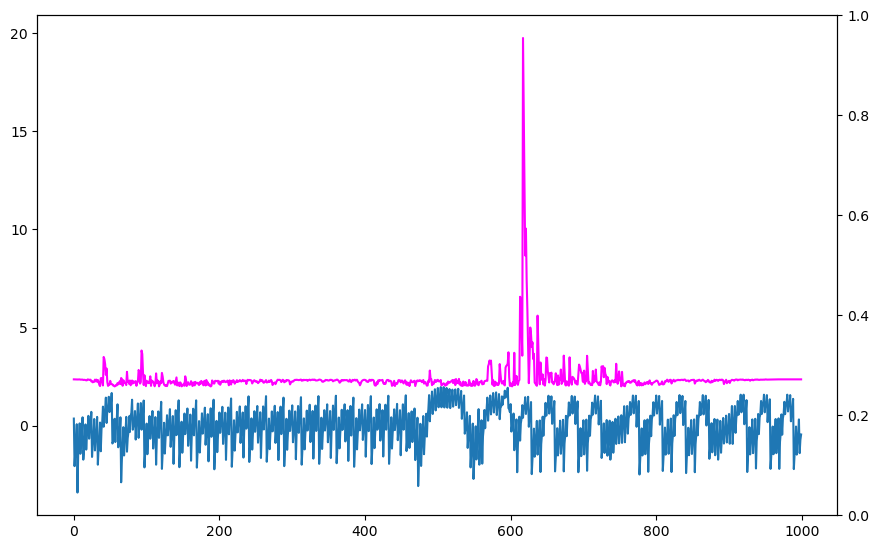

In [46]:
fig = plt.figure(1,(8.0, 5.0))

ax = fig.add_axes((1.0, 1.0, 1.0, 1.0))
#ax.set_ylim(200.0, 700.0)

grads_mean = grads.cpu().mean()
grads_std =  grads.cpu().std()
grads_norm = (grads.cpu() - grads_mean) / grads_std

ax.plot(np.arange(1000), grads_norm.abs() + 2.0, color='magenta', alpha=1.0)

test_trace = val_test_traces[141][0][:1000]
test_trace_mean = test_trace.mean()
test_trace_std = test_trace.std()
test_trace_norm = (test_trace - test_trace_mean) / test_trace_std

ax2 = ax.twinx()
ax.plot(np.arange(1000), test_trace_norm)

print(test_trace.argmax())
